# Testing Grid Resolution : 

- SGD-Adam PyTorch and Autograd
- Best learning rate from test_0
- Epoch = 100
- Arcitecture still [2,2] 

In [2]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src import *

In [3]:
##################################################################################
# CONFIGURATION INFORMATION : 
##################################################################################
# NETWORK ARCITECTURE : 
num_hidden_neurons = [2,2]  # A simple network just for testing
opt_met_pytorch    = 'SGD-adam'
opt_met_autograd   = 'SGD-adam'
# HYPERPARAMETERS : 
epochs         = 100   
learning_rate  = 0.01 # Concluded this is the best
seed           = 36   # Most similar seed for numpy.random.seed and PyTorch.manual_seed
# ONLY FOR SGD : 
batch_fraction = 0.012
Nx_testing = [10, 30, 60, 90, 120] # Spatial resolution of Rod
Nt_testing = [10, 30, 60, 90, 120] # Temporal lenght
# MAKE X AND T (Just for config now): 
batch_size_list = []
for Nx, Nt in zip(Nx_testing,Nt_testing):
    t, x, t_torch, x_torch, batch_size = create_t_and_x_batch_size(Nx,
                                                                   Nt,
                                                                   batch_fraction)
    batch_size_list.append(batch_size)
# CONFIGURATION INFORMATION : 
config = make_config(Nx_testing,
                     Nt_testing, 
                     num_hidden_neurons,
                     opt_met_pytorch, 
                     epochs, 
                     learning_rate, 
                     batch_fraction,
                     batch_size_list,
                     seed,
                     verbose=True)

--------------------------------------
Configuration information :

Grid resolution         : Nx=[10, 30, 60, 90, 120], Nt=[10, 30, 60, 90, 120]
Network architecture    : [2, 2]
Gradient decent method  : SGD-adam
Learning rate           : 0.01
Epochs                  : 100
Batch fraction          : 0.012
Batch size              : [1, 10, 43, 97, 172]
Seed                    : 36
--------------------------------------


In [3]:
##################################################################################
# FUNCTION TO SET UP PARAMETERS :
##################################################################################
def set_up_test_grid_res(Nx,
                         Nt, 
                         opt_met):
    ##################################################################################
    # MAKE X AND T : 
    ##################################################################################
    t, x, t_torch, x_torch, batch_size = create_t_and_x_batch_size(Nx,
                                                                   Nt,
                                                                   batch_fraction)
    ##################################################################################
    # CONFIGURATION INFORMATION : 
    ##################################################################################
    config = make_config(Nx,
                         Nt, 
                         num_hidden_neurons,
                         opt_met, 
                         epochs, 
                         learning_rate, 
                         batch_fraction,
                         batch_size,
                         seed,
                         verbose=False)
    return t, x, t_torch, x_torch, batch_size, config
##################################################################################
# FUNCTION TO TRAIN THE PINN :
##################################################################################
def compare_cost_and_time_A(optimization_method,
                            learning_rate, 
                            t, 
                            x, 
                            batch_size):
    start_time = time.time()
    P, history = train_PINN_autograd(x,
                                     t,
                                     num_hidden_neurons,
                                     epochs,
                                     learning_rate,
                                     'tanh',
                                     seed,
                                     optimization_method=optimization_method,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     replacement=False,
                                     verbose=False,
                                     debug=False)
    end_time = time.time()
    tot_time = end_time - start_time
    return tot_time, history, P
def compare_cost_and_time_P(optimization_method,
                            learning_rate, 
                            t_torch, 
                            x_torch, 
                            batch_size):
    start_time = time.time()
    P, history = train_PINN_pyTorch(x_torch,
                                    t_torch,
                                    num_hidden_neurons,
                                    epochs,
                                    learning_rate,
                                    'tanh',
                                    seed,
                                    optimization_method=optimization_method, 
                                    batch_size=batch_size,
                                    shuffle=True,
                                    replacement=False,
                                    verbose=False,
                                    debug=False)
    end_time = time.time()
    tot_time = end_time - start_time
    return tot_time, history, P

In [ ]:
results_A  = {}
results_P  = {}
for Nt, Nx in zip(Nt_testing, Nx_testing):
    print('----------------------------------')
    print(f'Nt, Nx : {Nt, Nx}')
    print('----------------------------------')
    ##################################################################################
    # SET UP TEST GRID RESOLUTION : 
    ##################################################################################
    t, x, t_torch, x_torch, batch_size, config = set_up_test_grid_res(Nx,
                                                                      Nt,
                                                                      opt_met_pytorch)
    print(f'Batch size     : {batch_size}')
    print(f'Learning rate  : {learning_rate}')
    print(f'Implementation : {opt_met_pytorch}')
    print()
    ##################################################################################
    # TRAIN PINN FOR EACH GRID RESOLUTION : 
    ##################################################################################
    print('------------ Autograd ------------')
    print('...')
    print('------------ PyTorch ------------')
    tot_timeP, historyP, PP = compare_cost_and_time_P(opt_met_pytorch,
                                                      learning_rate, 
                                                      t_torch, 
                                                      x_torch, 
                                                      batch_size)
    PINN_P_solution    = PINN_solution(Nx,Nt,x_torch,t_torch,Net,PP,num_hidden_neurons,'tanh','pytorch')
    print('---------- Analytical ----------')
    analytical_solut       = analytical_solution(Nx,Nt,x_torch,t_torch)
    diff_PINN_P_analytic   = np.max(np.abs(PINN_P_solution - analytical_solut))
    #results_A[(Nt, Nx)] = {'time': tot_timeA, 'history': historyA}#, 'P': PA}
    results_P[(Nt, Nx)] = {'time': tot_timeP, 'history': historyP, 'P': PP, 'MAD': diff_PINN_P_analytic}
    print()

----------------------------------
Nt, Nx : (10, 10)
----------------------------------
Batch size     : 1
Learning rate  : 0.01
Implementation : SGD-adam

------------ Autograd ------------
------------ PyTorch ------------
Initial cost:  36.991859436035156
Final cost:  14.127636909484863
---------- Analytical ----------

----------------------------------
Nt, Nx : (30, 30)
----------------------------------
Batch size     : 10
Learning rate  : 0.01
Implementation : SGD-adam

------------ Autograd ------------
------------ PyTorch ------------
Initial cost:  39.63385009765625
Final cost:  12.8935546875
---------- Analytical ----------

----------------------------------
Nt, Nx : (60, 60)
----------------------------------
Batch size     : 43
Learning rate  : 0.01
Implementation : SGD-adam

------------ Autograd ------------
------------ PyTorch ------------
Initial cost:  40.30277633666992
Final cost:  12.581729888916016
---------- Analytical ----------

------------------------------

### Plotting : 

Saved figure to /Users/jennyguldvog/FYS-STK4155-Project-3/code/main_clean/outputs/test1_cost_and_mad_vs_grid.pdf


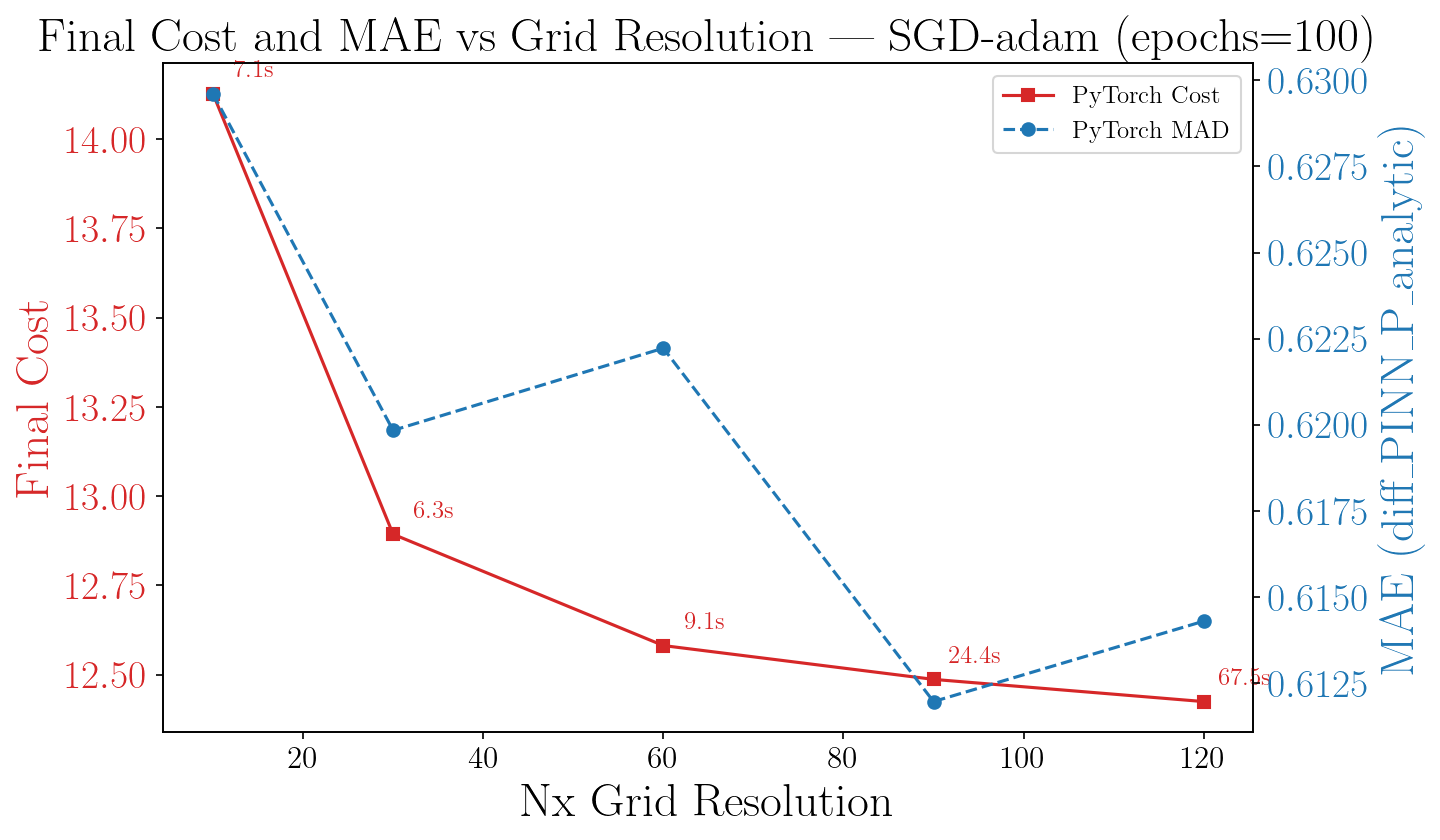

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare lists
Nx_list = []
costs_P = []
times_P = []
mads_P = []

for Nt, Nx in zip(Nt_testing, Nx_testing):
    Nx_list.append(Nx)
    costs_P.append(results_P[(Nt, Nx)]['history']['cost'][-1])
    times_P.append(results_P[(Nt, Nx)]['time'])
    entry = results_P[(Nt, Nx)]
    if 'history' in entry and 'MAD' in entry['history']:
        mads_P.append(entry['history']['MAD'][-1])
    elif 'diff_PINN_P_analytic' in entry:
        mads_P.append(entry['diff_PINN_P_analytic'])
    elif 'MAD' in entry:
        mads_P.append(entry['MAD'])
    else:
        # fallback: NaN so plotting won't crash
        mads_P.append(np.nan)
try:
    x_vals = np.array(Nx_list, dtype=float)
    xtick_labels = None
except Exception:
    x_vals = np.arange(len(Nx_list))
    xtick_labels = Nx_list

# Sort by x to ensure connected lines go left-to-right
order = np.argsort(x_vals)
x_sorted = x_vals[order]
costs_P_sorted = np.array(costs_P)[order]
times_P_sorted = np.array(times_P)[order]
mads_P_sorted = np.array(mads_P)[order]
nx_labels_sorted = np.array(Nx_list)[order] if xtick_labels is not None else None

fig, ax = plt.subplots(figsize=(10,6))

# Left axis: Final Cost (with time annotations)
hP, = ax.plot(x_sorted, costs_P_sorted, marker='s', linestyle='-', color='tab:red',
              label='PyTorch Cost')
for xi, cp, tp in zip(x_sorted, costs_P_sorted, times_P_sorted):
    ax.annotate(f'{tp:.1f}s', xy=(xi, cp), xytext=(20, 8),
                textcoords='offset points', ha='center', fontsize=12, color='tab:red')

ax.set_xlabel('Nx Grid Resolution')
ax.set_ylabel('Final Cost', color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')

# Right axis: MAD (no time annotation)
ax2 = ax.twinx()
hMAD, = ax2.plot(x_sorted, mads_P_sorted, marker='o', linestyle='--', color='tab:blue',
                 label='PyTorch MAE')
ax2.set_ylabel('MAE (diff_PINN_P_analytic)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combined legend
ax.legend(handles=[hP, hMAD], loc='best')

if xtick_labels is not None:
    ax.set_xticks(x_sorted)
    ax.set_xticklabels(nx_labels_sorted)

plt.title(f'Final Cost and MAE vs Grid Resolution — {opt_met_pytorch} (epochs={epochs})')
plt.tight_layout()
save_fig('test1_cost_and_mad_vs_grid')
plt.show()
